In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the required libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
keras version 2.4.3
tensorflow version 2.4.1


In [ ]:
## The location of the Flickr8K_ images
dir_jpg = "/content/drive/MyDrive/image_cap/image captioning 8k/Image_Dataset/"
## The location of the caption file
dir_text = "/content/drive/MyDrive/image_cap/image captioning 8k/text/token.txt"

jpgs = os.listdir(dir_jpg)
print("The number of jpg flies: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [ ]:
#Finding the captions for each image.
file = open(dir_text,'r', encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename  ...                                            caption
0  1000268201_693b08cb0e.jpg  ...  a child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg  ...              a girl going into a wooden building .
2  1000268201_693b08cb0e.jpg  ...   a little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  ...  a little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  ...  a little girl in a pink dress going into a woo...

[5 rows x 3 columns]


## Cleaning captions for further analysis

In [ ]:
# Defining a function to calculate the top 3 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975


## Cleaning the captions for further processing
The caption dataset contains punctuations, singular words and numerical values that need to be cleaned before it is fed to the model because uncleaned dataset will not create good captionsfor the images

In [ ]:
import string
# text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"
text_original = "I like pets very much. I have 2 dogs and 1 cat. I really love playing with them."


print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I like pets very much. I have 2 dogs and 1 cat. I really love playing with them.

Remove punctuations..
I like pets very much I have 2 dogs and 1 cat I really love playing with them

Remove a single character word..
 like pets very much have dogs and cat really love playing with them

Remove words with numeric values..
    like       : True
    pets       : True
    very       : True
    much       : True
    have       : True
    dogs       : True
    and        : True
    cat        : True
    really     : True
    love       : True
    playing    : True
    with       : True
    them       : True
 like pets very much have dogs and cat really love playing with them


In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

## Adding start and end sequence tokens for each captions 
Start and end sequence has to be added to the tokens so that it is easier to identify the captions for the images as each of them are of different length

In [ ]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [ ]:
df_txt0[:5]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...


## Loading VGG16 model and weights to extract features from the images


In [ ]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True)
## load the locally saved weights 
modelvgg.load_weights("/content/drive/MyDrive/image_cap/image captioning 8k/vgg16_weights.h5")
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Using VGG16 model for extracting the features

In [ ]:
from keras import models
modelvgg._layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Feature extraction
Here the features are extracted from all the images in the dataset. VGG-16 model gives out 4096 features from the input image of size 224 * 224

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224 #image size is fixed at 224 because VGG16 model has been pre-trained to take that size.
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

## Merging the images and the captions for training

In [ ]:
dimages, keepindex = [],[]

# Creating a datframe where only first caption is taken for processing
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

#fnames are the names of the image files        
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"].iloc[keepindex].values
#dimages are the actual features of the images
dimages = np.array(dimages)

In [ ]:
df_txt0[:5]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
5,1001773457_577c3a7d70.jpg,0,startseq black dog and spotted dog are fighti...
10,1002674143_1b742ab4b8.jpg,0,startseq little girl covered in paint sits in...
15,1003163366_44323f5815.jpg,0,startseq man lays on bench while his dog sits...
20,1007129816_e794419615.jpg,0,startseq man in an orange hat starring at som...


## Tokenizing the captions for further processing
As the model can't take texts as an input, they need to converted into vectors.

In [ ]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [ ]:
import pickle
with open('/content/drive/MyDrive/image_cap/image captioning 8k/model_tokenizer', 'wb') as file_pi:
  pickle.dump(tokenizer, file_pi)

## Splitting the training and test data

In [ ]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

## Finding the max length of the caption

In [ ]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


## Processing the captions and images as per the required shape by the model

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49631, 30) (49631, 1000) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 1000) (16353, 4476)


In [ ]:
Ximage_train.shape[1]

1000

## Building the LSTM model

In [ ]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
vocab_size=4476
print(vocab_size)
maxlen=30
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(4096,))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)

se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256,name="CaptionFeature2")(se2)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 64)       286464      input_5[0][0]                    
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 30, 256)      328704      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 30, 256)      0           CaptionFeature[0][0]             
_______________________________________________________________________________________

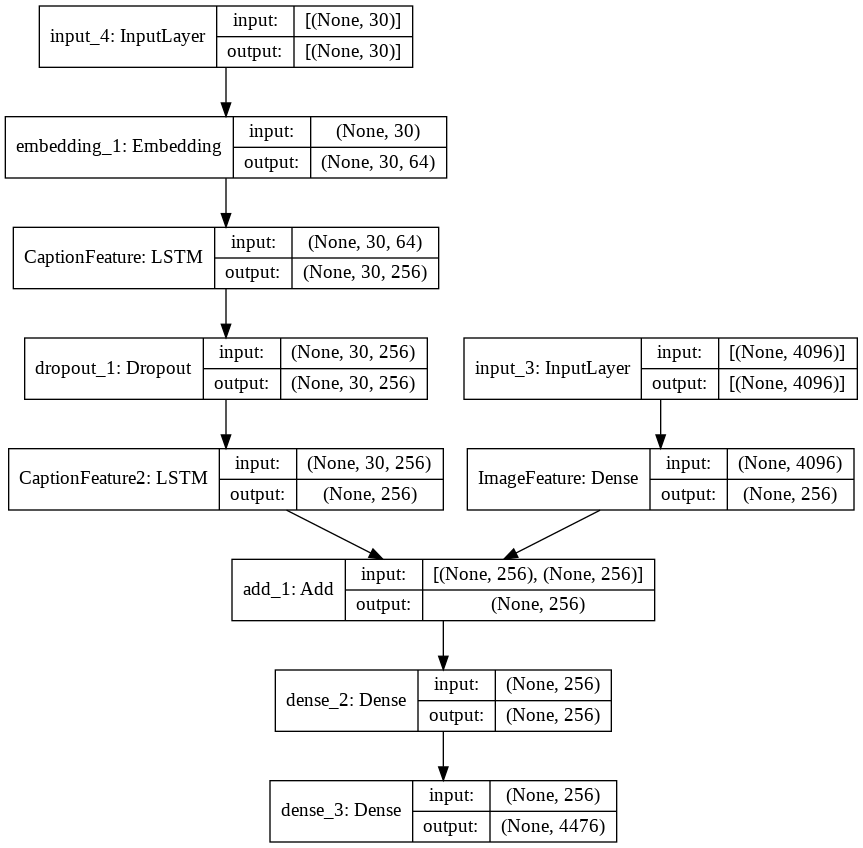

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

## Training the LSTM model

In [ ]:
# fit model
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=6, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),callbacks=[tensorboard])


Train on 49631 samples, validate on 16353 samples
Epoch 1/6
 - 463s - loss: 5.3759 - val_loss: 4.8776
Epoch 2/6
 - 460s - loss: 4.5156 - val_loss: 4.5810
Epoch 3/6
 - 455s - loss: 4.1009 - val_loss: 4.4676
Epoch 4/6
 - 456s - loss: 3.8300 - val_loss: 4.4382
Epoch 5/6
 - 460s - loss: 3.6239 - val_loss: 4.4181
Epoch 6/6
 - 460s - loss: 3.4465 - val_loss: 4.4253


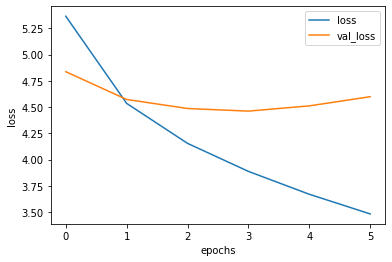

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/drive/MyDrive/image_cap/image captioning 8k/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/image_cap/image captioning 8k/Image_Caption_Generator.h5")

## Evaluating the model performance
After the model is trained we have to test the models prediction capabilities on test dataset. Traditional accuracy metric can't be used on predictions. For text evaluations we have a metric called as [BLEU Score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/). BLEU stands for Bilingual Evaluation Understudy, it is a score for comparing a candidate text to one or more reference text.

Example:

In [ ]:
hypothesis = "I like dog"
hypothesis = hypothesis.split()
reference  = "I do like dog"
references = [reference.split()] ## references must be a list containing list. 

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
print("BLEU={:4.3f}".format(sentence_bleu(references,hypothesis)))

BLEU=0.603


In [ ]:
hypothesis2 = "I love dog!".split()
print("BLEU={:4.3f}".format(sentence_bleu(references,  hypothesis2))) 

BLEU=0.544


## Generating captions for the whole test data and finding BLEU score

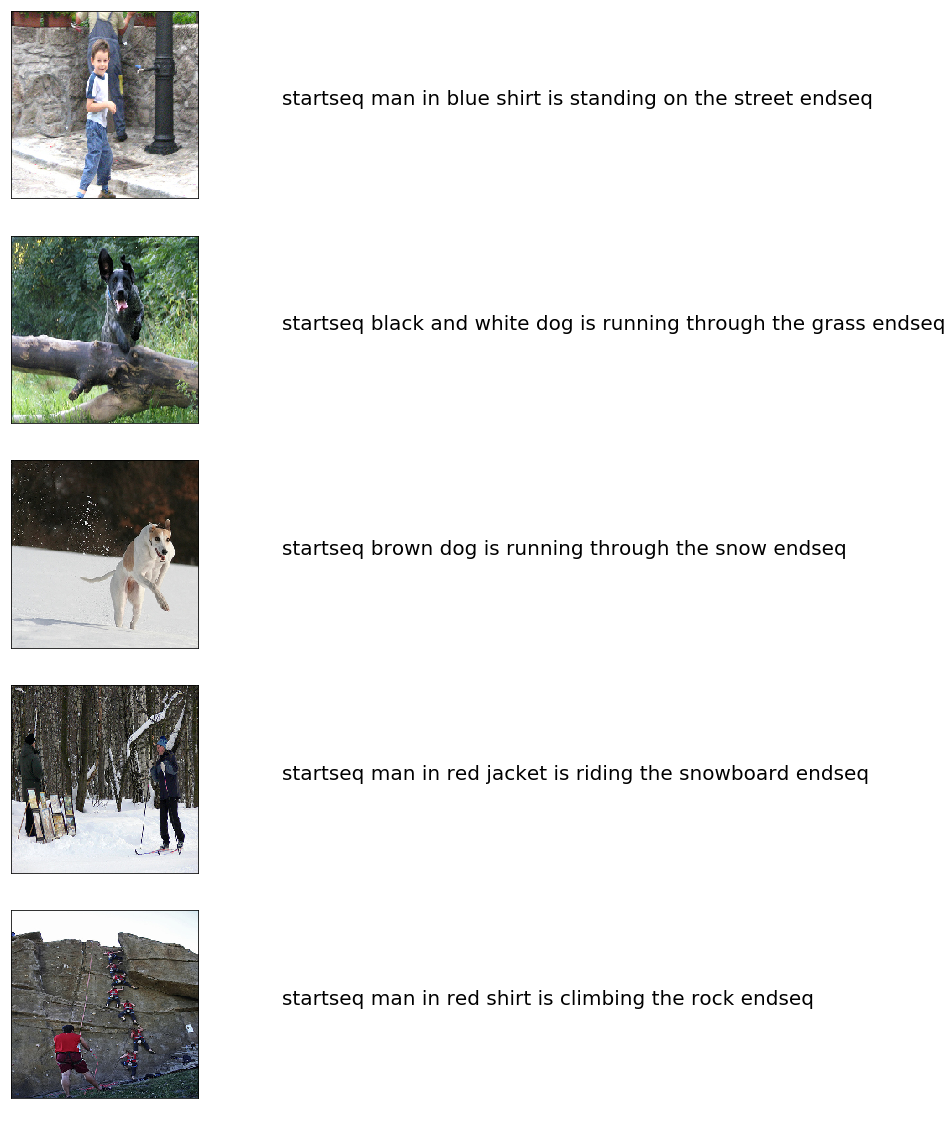

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[8:13],di_test[8:13]):
    ## images 
    filename = dir_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


In [ ]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.401
